### Imports

In [1]:
%matplotlib widget
import gym
from dqn import DQN, Model, AggregateModel, BaseModel, SampleModel, BadModel
from v1.utils import linear_decay_clip
import numpy as np
import torch

### Load MountainCar-v0

In [3]:
env = gym.make('MountainCar-v0')

In [4]:
n_features = env.observation_space.shape[0]
n_actions = env.action_space.n
lows = env.observation_space.low
highs = env.observation_space.high
print(f'There are {n_features} features & {n_actions} actions')
print(f'Car Position ranges from {lows[0]} to {highs[0]}')
print(f'Car Velocty ranges from {lows[1]} to {highs[1]}')

There are 2 features & 3 actions
Car Position ranges from -1.2000000476837158 to 0.6000000238418579
Car Velocty ranges from -0.07000000029802322 to 0.07000000029802322


### Create Model (Q-Value Function/Learner)

In [48]:
model = SampleModel(
    highs=highs,
    lows=lows,
    n_actions=n_actions,
    lr=0.1,
    batch_size=100)

In [49]:
state = env.observation_space.sample()
q_values = model.q_values(state)
print(f'State {state} -> Q-Values {q_values}')

State [0.39227057 0.06362094] -> Q-Values [-0.06997582 -0.1714769   0.28832003]


### Train DQN

In [60]:
dqn = DQN(
    env=env,
    gamma=1,
    epsilon=linear_decay_clip(0.5, 0.5, 100000),
    model=model,
    capacity=100000,
    warmup_steps=100000,
    train_steps=1,
    update_steps=100000,
    sample_size=100000)

### Test

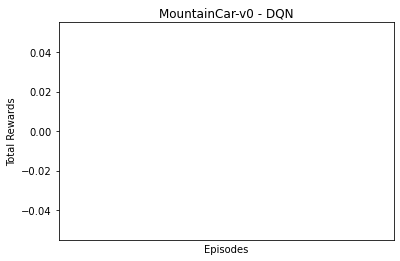

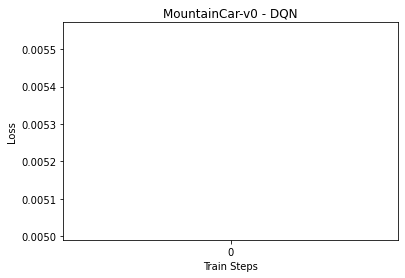

In [61]:
%matplotlib inline
dqn.plot_stats(title='MountainCar-v0 - DQN')

In [62]:
%matplotlib qt
dqn.plot_2d_value_function(
    intervals=10, 
    labels=('State Value', 'Position', 'Velocity'),
    title='MountainCar-v0 - DQN',
    invert_v=True,
    anim=False)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Test

In [63]:
dqn.test()

199


### Debug

In [10]:
model2 = AggregateModel(
    lows=lows, 
    highs=highs, 
    buckets=10, 
    n_actions=n_actions, 
    lr=0.1)
dqn2 = DQN(
    env=env,
    gamma=1,
    epsilon=linear_decay_clip(0, 0, 400),
    model=model2,
    capacity=1,
    warmup_steps=1,
    train_steps=10000,
    update_steps=1,
    sample_size=1)

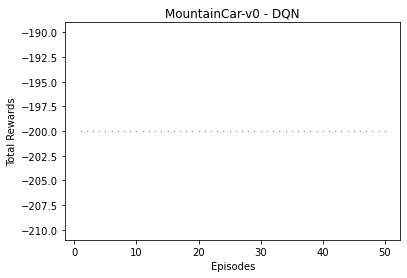

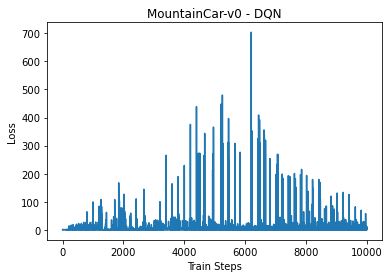

In [11]:
%matplotlib inline
dqn2.plot_stats(title='MountainCar-v0 - DQN')

In [12]:
%matplotlib qt
dqn2.plot_2d_value_function(
    intervals=10, 
    labels=('State Value', 'Position', 'Velocity'),
    title='MountainCar-v0 - DQN',
    invert_v=True,
    anim=False)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [9]:
dqn2.test()

199


In [48]:
intervals = 10
xs=np.linspace(lows[0], highs[0], intervals, dtype=np.float32)
ys=np.linspace(lows[1], highs[1], intervals, dtype=np.float32)
xys = np.dstack(np.meshgrid(xs, ys)).reshape(-1, 2)
vs = np.array([model2.q_values(xy) for xy in xys])

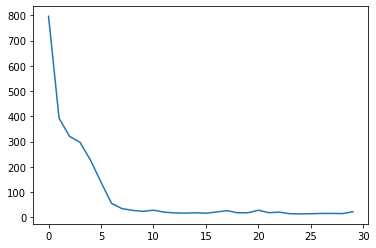

In [167]:
%matplotlib inline
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from utils import normaliser
class SampleModel(nn.Module, Model):
    def __init__(self, lows, highs, n_actions, lr):
        assert(len(lows) == len(highs))
        super().__init__()
        n_features = len(lows)
        self.norm = normaliser(lows, highs)
        self.fc1 = nn.Linear(n_features, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, n_actions)
        self.opt = optim.Adam(self.parameters(), lr=lr)
    def forward(self, x):
        x = self.norm(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    def q_values(self, state):
        with torch.no_grad():
            x = torch.tensor(state, dtype=torch.float32) # pylint: disable=not-callable
            return self.forward(x).numpy()
model = SampleModel(
    highs=highs,
    lows=lows,
    n_actions=n_actions,
    lr=0.01)
# model = AggregateModel(
#     lows=lows, 
#     highs=highs, 
#     buckets=10, 
#     n_actions=n_actions, 
#     lr=0.1)
ds = TensorDataset(
    torch.tensor(xys, dtype=torch.float), 
    torch.tensor(vs, dtype=torch.float))
dl = DataLoader(ds, batch_size=10, shuffle=True)
losses = []
for epoch in tqdm(range(30)):
    total_loss = 0
    for xb, yb in dl:
#         for x, y in zip(xb, yb): 
#             for i in range(3): 
#                 model.update(x, i, y[i])
        loss = F.mse_loss(model(xb), yb)
        loss.backward()
        model.opt.step()
        model.opt.zero_grad()
        total_loss += loss * len(xb)
    losses.append(total_loss / len(ds))
plt.plot(range(len(losses)), losses)
plt.show()

In [168]:
%matplotlib qt
plot_2d_value_function(
    vf=lambda states: [np.amax(model.q_values(state)) for state in states],
    env=env,
    intervals=10, 
    labels=('State Value', 'Position', 'Velocity'),
    title='MountainCar-v0 - DQN',
    invert_v=True,
    anim=False)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [93]:
%matplotlib qt
model = SampleModel(
    highs=highs,
    lows=lows,
    n_actions=n_actions,
    lr=0.001)
for epoch in tqdm(range(1)):
    for xy, v in zip(xys, vs):
        for i in range(3):
            model.update(xy, i, v[i])
plot_2d_value_function(
    vf=lambda states: [np.amax(model.q_values(state)) for state in states],
    env=env,
    intervals=10, 
    labels=('State Value', 'Position', 'Velocity'),
    title='MountainCar-v0 - DQN',
    invert_v=True,
    anim=False)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …